# Imports

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
from acquire import get_connection, new_telco_data, get_telco_data
from prepare import clean_telco, impute_mode, train_validate_test_split,impute_mode, prep_telco_data
import explore

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

## Get and clean data

In [2]:
# clean_telco, gets and preps the dataframe from SQL
df = clean_telco()

## Make sure it is correct

In [3]:
# verify clean_telco worked properly
df.head(2)

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,internet_service_type,payment_type,gender_male,one_year_contract,two_year_contract,credit_card_payment,e_check_payment,mailed_check_payment,dsl_internet,fiber_optic_internet
0,0003-MKNFE,0,0,0,9,1,1,0,0,0,...,DSL,Mailed check,1,0,0,0,0,1,1,0
1,0013-MHZWF,0,0,1,9,1,0,0,0,0,...,DSL,Credit card (automatic),0,0,0,1,0,0,1,0


In [4]:
df.shape

(7043, 28)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   int64  
 3   dependents             7043 non-null   int64  
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   int64  
 6   multiple_lines         7043 non-null   int64  
 7   online_security        7043 non-null   int64  
 8   online_backup          7043 non-null   int64  
 9   device_protection      7043 non-null   int64  
 10  tech_support           7043 non-null   int64  
 11  streaming_tv           7043 non-null   int64  
 12  streaming_movies       7043 non-null   int64  
 13  paperless_billing      7043 non-null   int64  
 14  monthly_charges        7043 non-null   float64
 15  tota

## Establish categorical, quantitative, target data

In [6]:
quant_vars = ['tenure','monthly_charges','total_charges']
cat_vars = list((df.columns).drop(quant_vars))
target = 'churn'

## Split the data

In [6]:
train, validate, test = train_validate_test_split(df)

In [7]:
# make sure all split data contains decreasing rows and equal columns

train.shape, validate.shape, test.shape

((3943, 28), (1691, 28), (1409, 28))

## Data Exploration

In [8]:
# explore.explore_univariate(train, cat_vars, quant_vars)

### Takeaways from univariate:
#### Observations:
- There are significantly more non-senior citizens than senior citizens
- There are a lot more customers with dependents
- Significantly more customers with phone service than without
- Less have online security, online backup, device protection, and tech support
- A lot more people churn than stay
- More customers are Month-to-month than in contracts
- Electronis check is the most popular payment method

#### Questions:
- Customers with phone service that have multiple lines?
- Customers with internet that have online services (i.e. online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies)

In [9]:
cat_vars = ['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']

In [10]:
# explore.explore_bivariate(train, 'churn', cat_vars, quant_vars)

### Bivariate:
#### Observations:
- REALLY LOW p-values
    - senior, partner, dependents, online_security, tech_support, paperless_billing, ***month-to_month***, fiber_optic_internet, one_year, two_year
- Real low p-values
    - online_backup, device_protection, streaming_tv, streaming_movies, 
- barely passes 95% confidence
    - multiple lines
- Not low
    - gender, phone_service
- Vast majority of churn happens before 30 months
- higher monthly bill increases churn

#### Questions:
- Do people with all online services churn more than customers without all of the online services?
- Are the really low p-values a good starting point?

# Does the amount of online services affect churn rates of our customers with internet service?
## Online services are:
   - online security
   - online backup
   - device protection
   - tech supprt
   - streaming tv
   - streaming movies

In [11]:
# Cleaning train, validate and test. 

# only need customers with internet service 
train = train[train.internet_service_type != 'None']
validate = validate[validate.internet_service_type != 'None']
test = test[test.internet_service_type != 'None']

In [16]:
train.shape

(3105, 9)

In [15]:
# Unecessary information for statistics and modeling

dropcols = ['customer_id','internet_service_type','senior_citizen','partner','dependents','tenure','phone_service','multiple_lines','paperless_billing','monthly_charges','total_charges','contract_type','payment_type','gender_male','one_year_contract','two_year_contract','credit_card_payment','e_check_payment','mailed_check_payment']
train = train.drop(columns=dropcols)
validate = validate.drop(columns=dropcols)
test = test.drop(columns=dropcols)

In [17]:
train.columns

Index(['online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'churn', 'dsl_internet',
       'fiber_optic_internet'],
      dtype='object')

In [18]:
# adding the column n_services: the sum of all of the extra internet services: 
#     "online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies"

train = train.assign(n_services = train[train.columns[:6]].sum(axis=1))
validate = validate.assign(n_services = validate[validate.columns[:6]].sum(axis=1))
test = test.assign(n_services = test[test.columns[:6]].sum(axis=1))

In [19]:
train.shape, validate.shape, test.shape

((3105, 10), (1324, 10), (1088, 10))

n_services 
_____________________

         chi2       p-value  degrees of freedom
0  242.747186  1.453760e-49                   6

observed:
 churn          0    1   All
n_services                 
0            198  217   415
1            301  229   530
2            383  209   592
3            448  175   623
4            375  104   479
5            272   41   313
6            145    8   153
All         2122  983  3105

expected:
             0           1
0  283.616747  131.383253
1  362.209340  167.790660
2  404.580998  187.419002
3  425.766828  197.233172
4  327.355233  151.644767
5  213.908535   99.091465
6  104.562319   48.437681


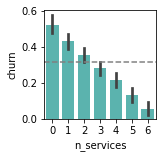


_____________________



In [27]:
explore.explore_bivariate_categorical(train, 'churn', 'n_services')

# Statistical Analysis


## χ<sup>2</sup> test
 - Testing for independence between 2 categorical values.
     - will use confidence level of 0.95 and alpha of 0.05
 - Churn is categorical (i.e. can be 1 or 0)
 - n_services is categorical (i.e. can be integers from 0-6)


In [28]:
# Χ^2 hypotheses:

h0 = 'Churn is independent of the number of online services per internet customer'
h1 = 'We assume that there is an association between churn and the number of online services'

In [29]:
confidence_level = .95
alpha = 1 - confidence_level

In [30]:
observed = pd.crosstab(train.churn, train.n_services)
observed

n_services,0,1,2,3,4,5,6
churn,,,,,,,
0,198,301,383,448,375,272,145
1,217,229,209,175,104,41,8


In [31]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(242.74718634895132,
 1.4537598284914964e-49,
 6,
 array([[283.61674718, 362.20933977, 404.58099839, 425.7668277 ,
         327.35523349, 213.90853462, 104.56231884],
        [131.38325282, 167.79066023, 187.41900161, 197.2331723 ,
         151.64476651,  99.09146538,  48.43768116]]))

In [32]:
if p < alpha:
    print(f"We reject the null hypothesis and move forward w/ the alternative hypothesis: \n{h1}")
else:
    print(f"We fail to reject the null hypothesis: {h0}")

We reject the null hypothesis and move forward w/ the alternative hypothesis: 
We assume that there is an association between churn and the number of online services


## T-test
    - I am running a T-test to verify that there is a difference between having no additional online services vs. having any extra online service
    - will continue to use the confidence level of 0.95 and alpha of 0.05

In [33]:
# T-test hypotheses 

h0 = 'There is no difference between in the means of customers without any additional online services and  customers with any number of online services.'
h1 = 'There is a difference in the means of customers with online services and those without online services.'

In [34]:
# customers without any additional online services
x1 = train[train.n_services == 0].mean()

# customers with any number of online services
x2 = train[train.n_services != 0].mean()

In [35]:
t,p = stats.ttest_ind(x1, x2)
t, p

(-2.1670563939302734, 0.043890077959799295)

In [36]:
if p < alpha:
    print(f"We reject the null hypothesis and move forward w/ the alternative hypothesis: \n{h1}")
else:
    print(f"We fail to reject the null hypothesis: {h0}")

We reject the null hypothesis and move forward w/ the alternative hypothesis: 
There is a difference in the means of customers with online services and those without online services.


# Modeling

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Baseline

In [74]:
train.churn.value_counts()

0    2122
1     983
Name: churn, dtype: int64

In [75]:
train["most_frequent"] = 0
baseline_accuracy = (train.churn == train.most_frequent).mean()
print(f'My baseline prediction is survived = 0')
print(f'My baseline accuracy is: {baseline_accuracy:.2%}')

My baseline prediction is survived = 0
My baseline accuracy is: 68.34%


## Logistic Regression

In [136]:
X_train = train.drop(columns=['churn','dsl_internet', 'fiber_optic_internet'])
y_train = train.churn

X_validate = validate.drop(columns=['churn','dsl_internet', 'fiber_optic_internet'])
y_validate = validate.churn

X_test = test.drop(columns=['churn','dsl_internet', 'fiber_optic_internet'])
y_test = test.churn

In [155]:
logit = LogisticRegression(penalty='l2', C=1, random_state=42, solver='lbfgs')

In [156]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=42)

In [157]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.68592399 -0.06325662 -0.09434156 -0.66258692  0.60265167  0.50300502
  -0.4004524   0.        ]]
Intercept: 
 [0.10459026]


In [158]:
y_pred = logit.predict(X_train)

In [159]:
y_pred_proba = logit.predict_proba(X_train)

In [160]:
print(f'The features used are : {list(X_train.columns)}\n\n')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}\n'
     .format(logit.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')

The features used are : ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'n_services', 'most_frequent']


Accuracy of Logistic Regression classifier on training set: 0.71

The confusion matrix:
 [[1809  313]
 [ 584  399]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      2122
           1       0.56      0.41      0.47       983

    accuracy                           0.71      3105
   macro avg       0.66      0.63      0.64      3105
weighted avg       0.69      0.71      0.70      3105



In [161]:
print('Accuracy of on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))
print('Accuracy out-of-sample set: {:.2f}'.format(logit.score(X_validate, y_validate)))

Accuracy of on training set: 0.71
Accuracy out-of-sample set: 0.71


## Decision tree

In [162]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [164]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

In [165]:
clf = clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=5, random_state=42)

In [166]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [167]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [201]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}\n'
      .format(clf.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n {classification_report(y_train, y_pred)}')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}\n')
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on training set: 0.73

The confusion matrix:
 [[1825  297]
 [ 542  441]]

Classificaiton Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      2122
           1       0.60      0.45      0.51       983

    accuracy                           0.73      3105
   macro avg       0.68      0.65      0.66      3105
weighted avg       0.72      0.73      0.72      3105

The True Positive Rate is: 44.86%
The False Positive Rate is: 14.00%
The True Negative Rate is: 86.00%
The False Negative Rate is: 55.14%

Accuracy of Decision Tree classifier on validate set: 0.72


## Random Forest

In [169]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [193]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            max_depth=50, 
                            random_state=42)

In [194]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=5, random_state=42)

In [195]:
print(rf.feature_importances_)

[0.21904131 0.059878   0.06519419 0.18529435 0.04525536 0.03463429
 0.1249111  0.08747859 0.1783128  0.        ]


In [196]:
y_pred = rf.predict(X_train)

In [197]:
y_pred_proba = rf.predict_proba(X_train)

In [198]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [199]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print(f'\nThe confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')
print('Accuracy of random forest classifier on the validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on training set: 0.73

The confusion matrix:
 [[1825  297]
 [ 542  441]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2122
           1       0.60      0.45      0.51       983

    accuracy                           0.73      3105
   macro avg       0.68      0.65      0.66      3105
weighted avg       0.72      0.73      0.72      3105


The True Positive Rate is: 44.86%
The False Positive Rate is: 14.00%
The True Negative Rate is: 86.00%
The False Negative Rate is: 55.14%
Accuracy of random forest classifier on the validate set: 0.72


## kNN

In [178]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [179]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [180]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [181]:
y_pred = knn.predict(X_train)

In [182]:
y_pred_proba = knn.predict_proba(X_train)

In [183]:
[tn,fp],[fn, tp] = confusion_matrix(y_train, y_pred)

In [184]:
tpr = (tp / (tp+fn))
fnr = (fn / (fn+tp))
tnr = (tn / (tn+fp))
fpr = (fp / (tn+fp))

In [185]:

print('Accuracy of KNN classifier on training set n_neighbors set to 5: {:.2f}'
     .format(knn.score(X_train, y_train)))
print(f'The confusion matrix:\n {confusion_matrix(y_train, y_pred)}\n')
print(f'Classificaiton Report:\n{classification_report(y_train, y_pred)}\n')
print(f'The True Positive Rate is: {tpr:.2%}')
print(f'The False Positive Rate is: {fpr:.2%}')
print(f'The True Negative Rate is: {tnr:.2%}')
print(f'The False Negative Rate is: {fnr:.2%}')
print('Accuracy of KNN classifier on validate set with n_neighbors set to 5: {:.2f}\n'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set n_neighbors set to 5: 0.71
The confusion matrix:
 [[1828  294]
 [ 606  377]]

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2122
           1       0.56      0.38      0.46       983

    accuracy                           0.71      3105
   macro avg       0.66      0.62      0.63      3105
weighted avg       0.69      0.71      0.69      3105


The True Positive Rate is: 38.35%
The False Positive Rate is: 13.85%
The True Negative Rate is: 86.15%
The False Negative Rate is: 61.65%
Accuracy of KNN classifier on validate set with n_neighbors set to 5: 0.70

